In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set_style("white")
# matplotlib.use('nbAgg')

project_name = "smol_one_fp32_neuron"
group_name = "v10_mega_sweep"
# print(os.environ.get("DISPLAY"))
# os.environ["DISPLAY"] = "localhost:0.0"
print(f"{plt.get_backend()=}")

plt.get_backend()='module://matplotlib_inline.backend_inline'


In [3]:
import wandb
api = wandb.Api()
runs = api.runs(f"haroun7/{project_name}", filters={"group": group_name})

print(f"Loading {len(runs)} runs from {group_name=}")

Loading 1080 runs from group_name='v10_mega_sweep'


In [37]:
%%time

datas = []
dfs = []
for run in runs:
    df = run.history()
    datas.append({
        "yhat": df.implicitly_estimated_threshold.iloc[-1],
        **run.config,
    })
    dfs.append({
        "df": df,
        **run.config,
    })

[D:2023-09-24 08:51:08,962][urllib3.connectionpool:1014] Starting new HTTPS connection (2): api.wandb.ai:443
[D:2023-09-24 08:51:09,599][urllib3.connectionpool:473] https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 1115
[D:2023-09-24 08:51:10,019][urllib3.connectionpool:473] https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 1808
[D:2023-09-24 08:51:10,503][urllib3.connectionpool:473] https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 1781
[D:2023-09-24 08:51:11,175][urllib3.connectionpool:473] https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 1775
[D:2023-09-24 08:51:11,634][urllib3.connectionpool:473] https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None
[D:2023-09-24 08:51:12,014][urllib3.connectionpool:473] https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None
[D:2023-09-24 08:51:12,361][urllib3.connectionpool:473] https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None
[D:2023-09-24 08:51:12,776][urllib3.connectionpool:473] https://api.wandb.ai:443 "POST

CPU times: user 11 s, sys: 738 ms, total: 11.8 s
Wall time: 8min 41s


In [38]:
import pandas as pd


data_df = pd.DataFrame.from_records(datas)

In [39]:
import numpy as np
data_df["error"] = data_df.apply(lambda row: np.abs(row.yhat - row.threshold), axis=1)
data_df["signed_error"] = data_df.apply(lambda row: row.yhat - row.threshold, axis=1)


<Axes: xlabel='error', ylabel='Density'>

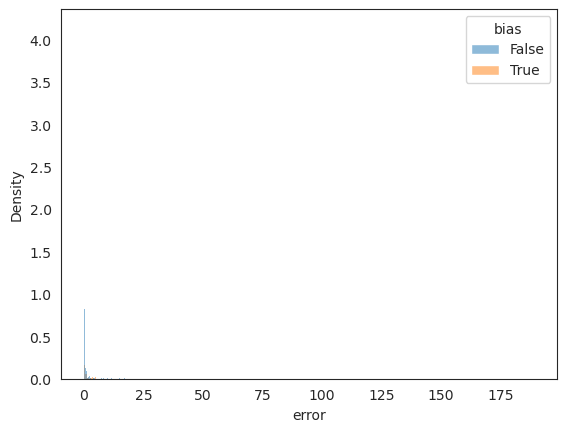

In [ ]:
sns.histplot(data=data_df, x="error", stat="density", hue="bias")

In [ ]:
# at 25 we see weirdness for sure
# same at 5?
valid_data_df = data_df#[data_df.error < 2.5]

<Axes: xlabel='lr', ylabel='error'>

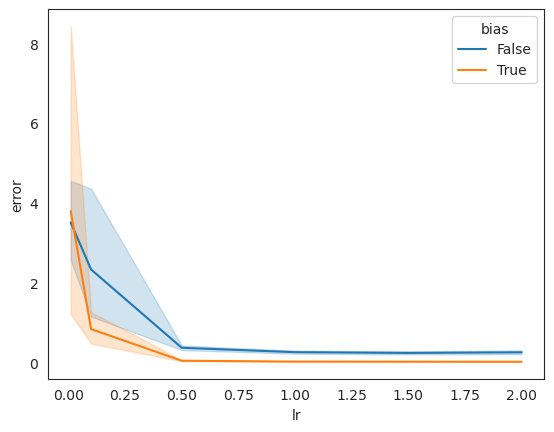

In [19]:
sns.lineplot(valid_data_df, x="lr", y="error", hue="bias")

<Axes: xlabel='batch_size', ylabel='error'>

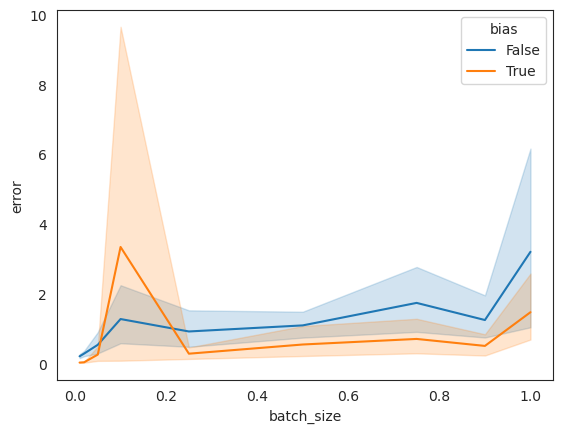

In [20]:
sns.lineplot(valid_data_df, x="batch_size", y="error", hue="bias")

<Axes: xlabel='n', ylabel='error'>

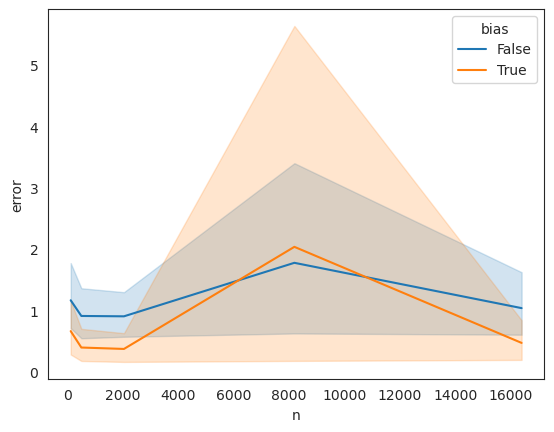

In [21]:
sns.lineplot(valid_data_df, x="n", y="error", hue="bias")

/tmp/ipykernel_393431/3997345688.py:50: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgs = [imageio.imread(filename) for filename in filenames]


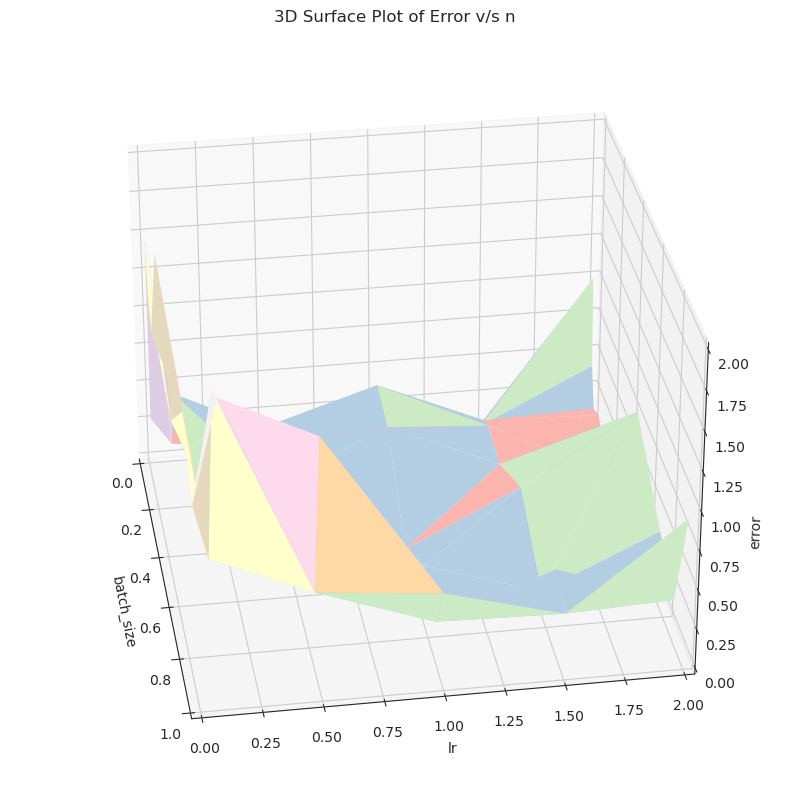

In [22]:
import imageio

e_max = 2.0

# Create a 3D surface plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# Plot the surface
error_np = data_df["error"].to_numpy()
movie_filename = "movie_bias_f.gif"
mask = (error_np < e_max) & (~data_df["bias"].to_numpy())
error_np = error_np[mask]
batch_size_np = data_df["batch_size"].to_numpy()[mask]
lr_np = data_df["lr"].to_numpy()[mask]
# n_np = valid_data_df["n"].to_numpy()

surface = ax.plot_trisurf(batch_size_np, lr_np, error_np, cmap=plt.cm.Pastel1, linewidth=0, antialiased=True) # cmap='viridis')#, c=n_np, )

# batch_size_mesh, lr_mesh = np.meshgrid(batch_size_np, lr_np)
# n_mesh, batch_size_mesh, lr_mesh = np.meshgrid(n_np, batch_size_np, lr_np)
# surface = ax.plot_surface(n_mesh, batch_size_mesh, lr_mesh, cmap='viridis', facecolors=plt.cm.viridis(error_np))


# fig.colorbar(surface, label='n')

# Set axis labels
ax.set_xlim(0, 1.0)
ax.set_ylim(0.0, 2.0)
ax.set_zlim(0.0, e_max)

ax.set_xlabel('batch_size')
ax.set_ylabel('lr')
ax.set_zlabel('error')
ax.set_title('3D Surface Plot of Error v/s n')
# plt.legend(loc="best")

dir_ = "outputs/error_3d"
os.makedirs(os.path.join(dir_, "temp_images"), exist_ok=True)
# plt.show()

filenames = []
# Show the plot
for i, azim in enumerate(range(1, 360, 10)):
    ax.view_init(elev=30, azim=azim)
    filename = os.path.join(dir_, "temp_images", f"movie{i}.png")
    plt.savefig(filename)
    filenames.append(filename)


imgs = [imageio.imread(filename) for filename in filenames]
imageio.mimsave(os.path.join(dir_, movie_filename), imgs, loop=0, duration=250)


# Variation over time

In [25]:
%%time
import copy

_end_of_epoch_dfs = []
for data in dfs:
    _df = data["df"].copy().reset_index()   # raw data, have to sub sample
    _df = _df[_df._step > 0]
    config = copy.copy(data)
    config.pop("df")  # still exists in data
    n_steps_per_epoch = int(_df.shape[0] / config["n_epochs"])
    df = _df.sort_values("step").iloc[::n_steps_per_epoch]

    # assert df.shape[0] == config["n_epochs"], f"{df.shape[0]=}, {_df.shape[0]=}, {config['n_epochs']=}, {n_steps_per_epoch=}"
    for k, v in config.items():
        if k in df.columns:
            logger.info(f"Weird, {k=}")
        df[k] = v
    df["epoch_idx"] = df.apply(lambda row: row.step // n_steps_per_epoch, axis=1)
    _end_of_epoch_dfs.append(df)
end_of_epoch_df = pd.concat(_end_of_epoch_dfs)

CPU times: user 1min 1s, sys: 259 ms, total: 1min 1s
Wall time: 1min 1s


In [26]:
%%time
end_of_epoch_df["error"] = end_of_epoch_df.apply(lambda row: np.abs(row.implicitly_estimated_threshold - row.threshold), axis=1)
end_of_epoch_df["sign_error"] = end_of_epoch_df.apply(lambda row: row.implicitly_estimated_threshold - row.threshold, axis=1)

<timed exec>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


CPU times: user 812 ms, sys: 90.1 ms, total: 903 ms
Wall time: 900 ms


<timed exec>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


In [27]:
%%time
# defrag
end_of_epoch_df = end_of_epoch_df.copy()

CPU times: user 413 ms, sys: 400 ms, total: 814 ms
Wall time: 813 ms


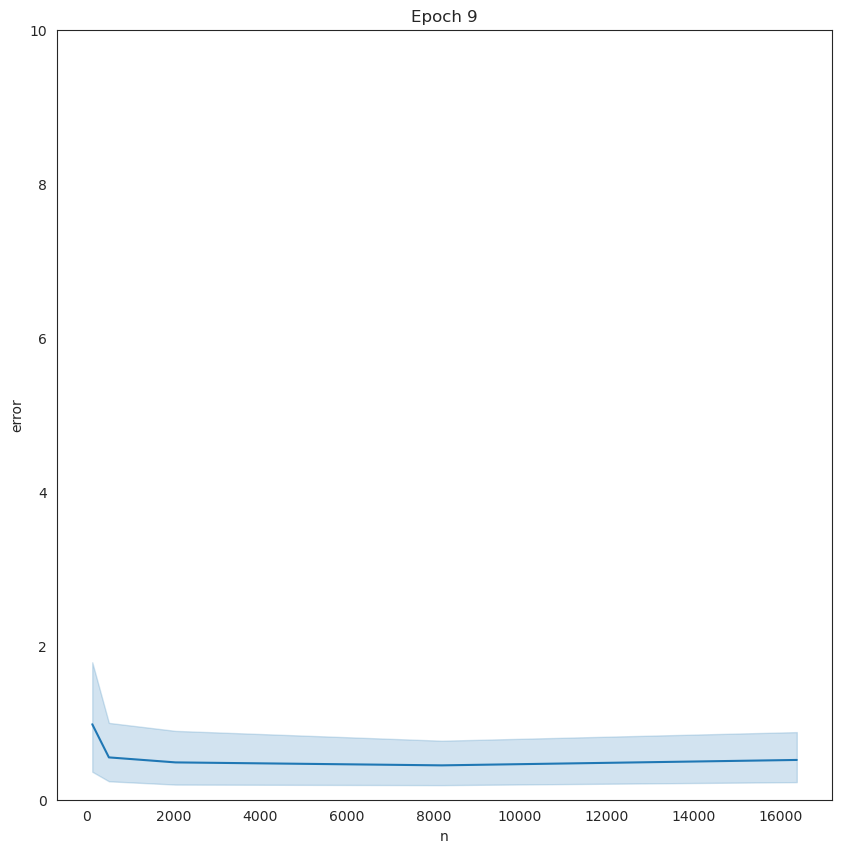

In [28]:
from matplotlib import animation
import functools


def do_everything(x_input: str):
    fig = plt.figure(figsize=(10, 10))

    def animate(i, x: str):
        assert i <= 10, f"got {i}"
        fig.gca().clear()
        fig.gca().set_ylim(0, 10)
        fig.gca().set_title(f"Epoch {i}")
        return sns.lineplot(
            end_of_epoch_df[
                (end_of_epoch_df.bias == True) & (end_of_epoch_df.epoch_idx == i)
            ], 
            x=x, y="error",
        )

    _x = x_input
    anim = animation.FuncAnimation(fig, functools.partial(animate, x=_x), frames=10, repeat=False, interval=1000)
    anim.save(f"outputs/temporal_error/vs_{_x}.gif")

do_everything("n")

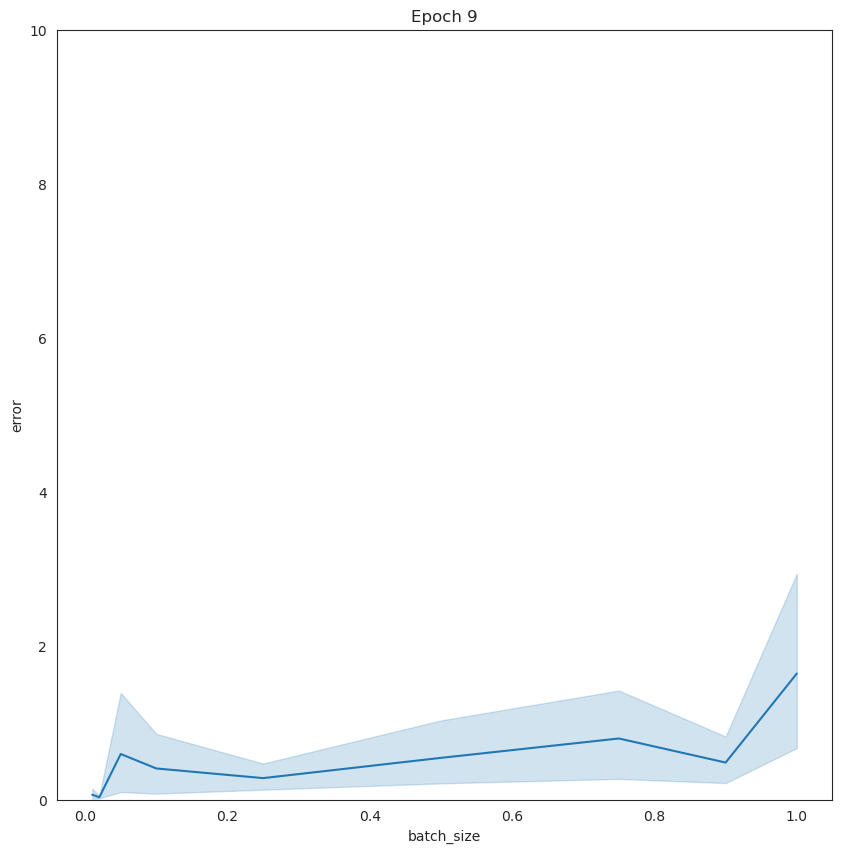

In [29]:
do_everything("batch_size")

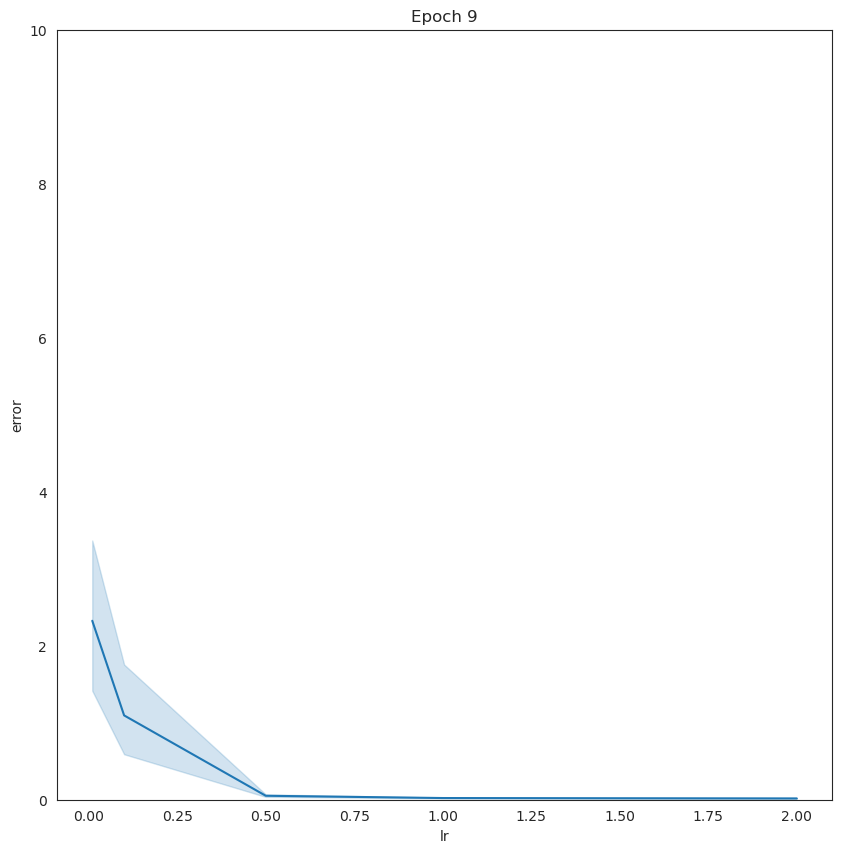

In [30]:
do_everything("lr")

# 3d temporal plot

[I:2023-09-24 08:20:02,602][matplotlib.animation:1052] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
[D:2023-09-24 08:20:02,604][matplotlib.animation:311] frame size in pixels is 1000 x 1000
[I:2023-09-24 08:20:02,604][matplotlib.animation:327] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1000x1000 -pix_fmt rgba -r 1.0 -i pipe: -filter_complex 'split [a][b];[a] palettegen [p];[b][p] paletteuse' -y outputs/temporal_error_3d/movie_bias_True_elb.gif
[D:2023-09-24 08:20:02,688][matplotlib.animation:354] MovieWriter.grab_frame: Grabbing frame.
[D:2023-09-24 08:20:02,811][matplotlib.animation:354] MovieWriter.grab_frame: Grabbing frame.
[D:2023-09-24 08:20:02,939][matplotlib.animation:354] MovieWriter.grab_frame: Grabbing frame.
[D:2023-09-24 08:20:03,063][matplotlib.animation:354] MovieWriter.grab_frame: Grabbing frame.
[D:2023-09-24 08:20:03,191][matplotlib.animation:354] MovieWriter.grab_frame: Grabbing frame.
[D:2023-09-24 08:20:03,316][mat

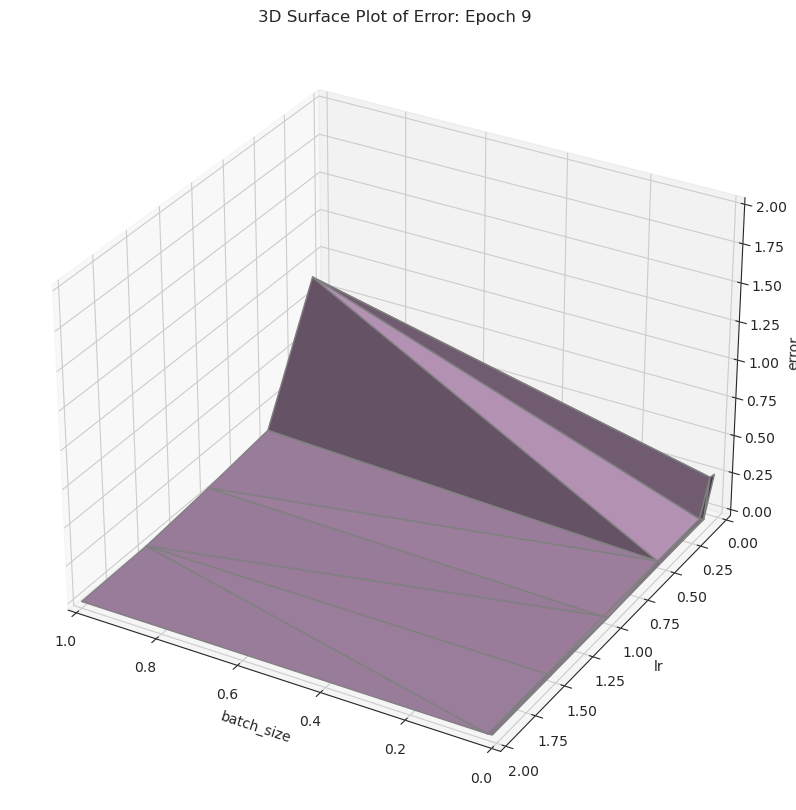

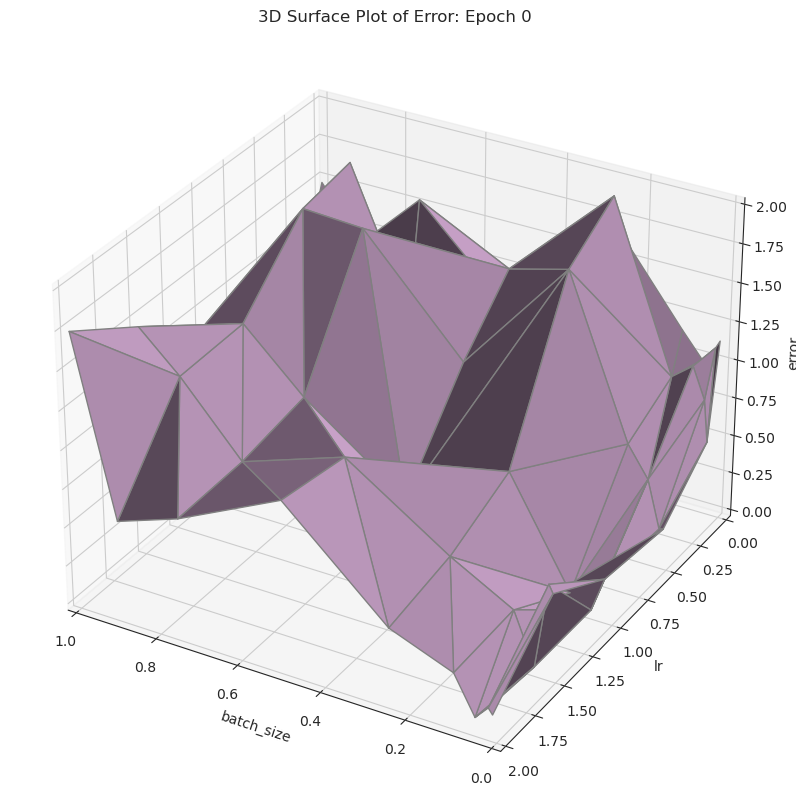

In [31]:
import imageio
import logging
from smol.utils import setup_logger  # does the setup
from smol.plotting import LILAC_RGB


logger = logging.getLogger(__name__)

e_max = 2.0

# Plot the surface
for bias in [True, False]:
    movie_filename = f"movie_bias_{bias}_elb.gif"
    mask = ((end_of_epoch_df.error < e_max).to_numpy()) & ((end_of_epoch_df.bias == bias).to_numpy())

    _df = end_of_epoch_df[mask]
    error_np = _df.error.to_numpy()
    epoch_idx_np = _df.epoch_idx.to_numpy().astype(int)
    batch_size_np = _df.batch_size.to_numpy()
    lr_np = _df.lr.to_numpy()
    n_np = _df.n.to_numpy()


    # Create a 3D surface plot
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    def animate(i):
        ax.clear()
        ax.view_init(elev=30, azim=120)
        epoch_idx_mask = epoch_idx_np.astype(int) == (i + 1)
        # logger.info(f"{i=}, {epoch_idx_mask.sum()=} {epoch_idx_mask[:3]=}, {epoch_idx_np[:3]=}")
        ax.set_xlim(0, 1.0)  # .. only for batch size
        surface = ax.plot_trisurf(
            batch_size_np[epoch_idx_mask], 
            # n_np[epoch_idx_mask], 
            lr_np[epoch_idx_mask], 
            error_np[epoch_idx_mask], 
            linewidth=1, 
            # cmap=plt.cm.Pastel1, 
            color=(*LILAC_RGB,1.0), edgecolor='Gray',
            antialiased=True,
        ) # cmap='viridis')#, c=n_np, )
        # Set axis labels
        ax.set_ylim(0.0, 2.0)
        ax.set_zlim(0.0, e_max)

        ax.set_xlabel('batch_size')
        ax.set_ylabel('lr')
        ax.set_zlabel('error')
        ax.set_title(f'3D Surface Plot of Error: Epoch {i}')
    # plt.legend(loc="best")

    # Make a funcanimation
    anim = animation.FuncAnimation(fig, animate, frames=10, repeat=False, interval=1000)
    anim.save(os.path.join("outputs/temporal_error_3d", movie_filename))



# heatmaps 
#### for error (color) and {batch_size, n, lr} (y) v/s time (x)

[D:2023-09-24 08:20:06,360][matplotlib.colorbar:876] locator: <matplotlib.ticker.AutoLocator object at 0x7f7ea0de9b10>
[D:2023-09-24 08:20:06,848][matplotlib.colorbar:876] locator: <matplotlib.ticker.AutoLocator object at 0x7f7e9f33a620>
[D:2023-09-24 08:20:07,325][matplotlib.colorbar:876] locator: <matplotlib.ticker.AutoLocator object at 0x7f7e9ed4e980>


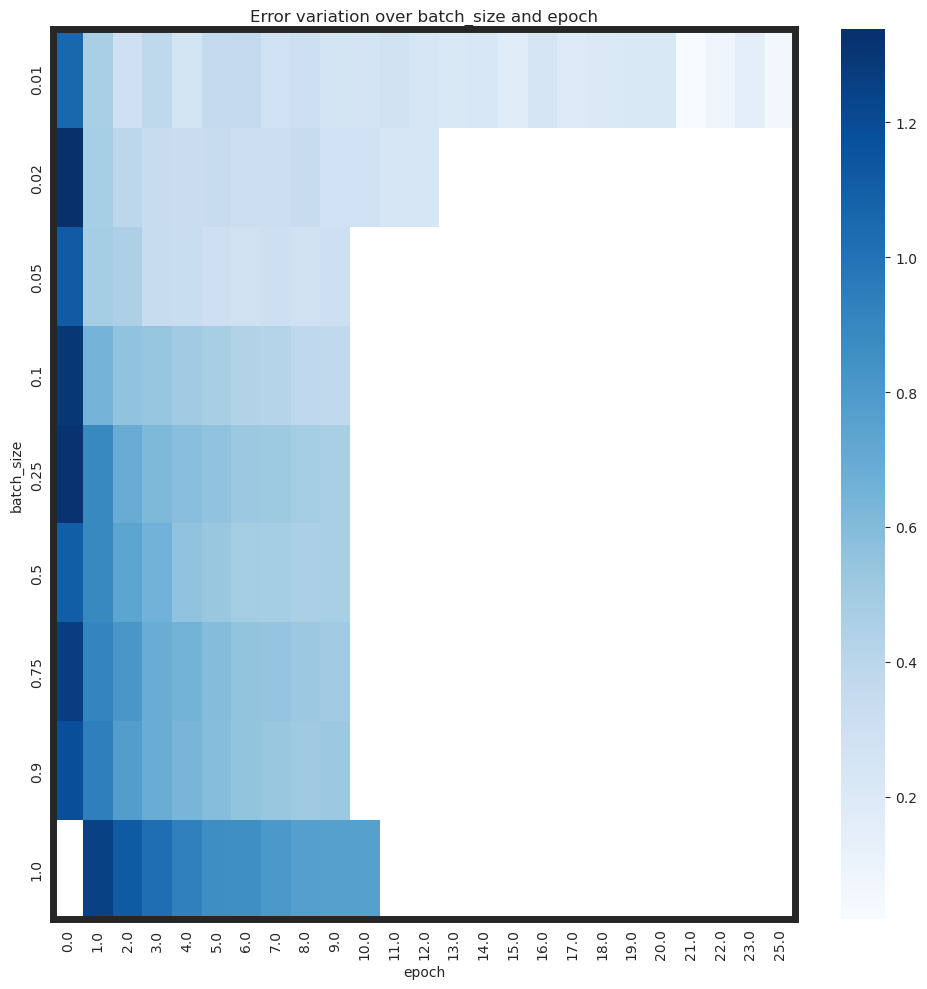

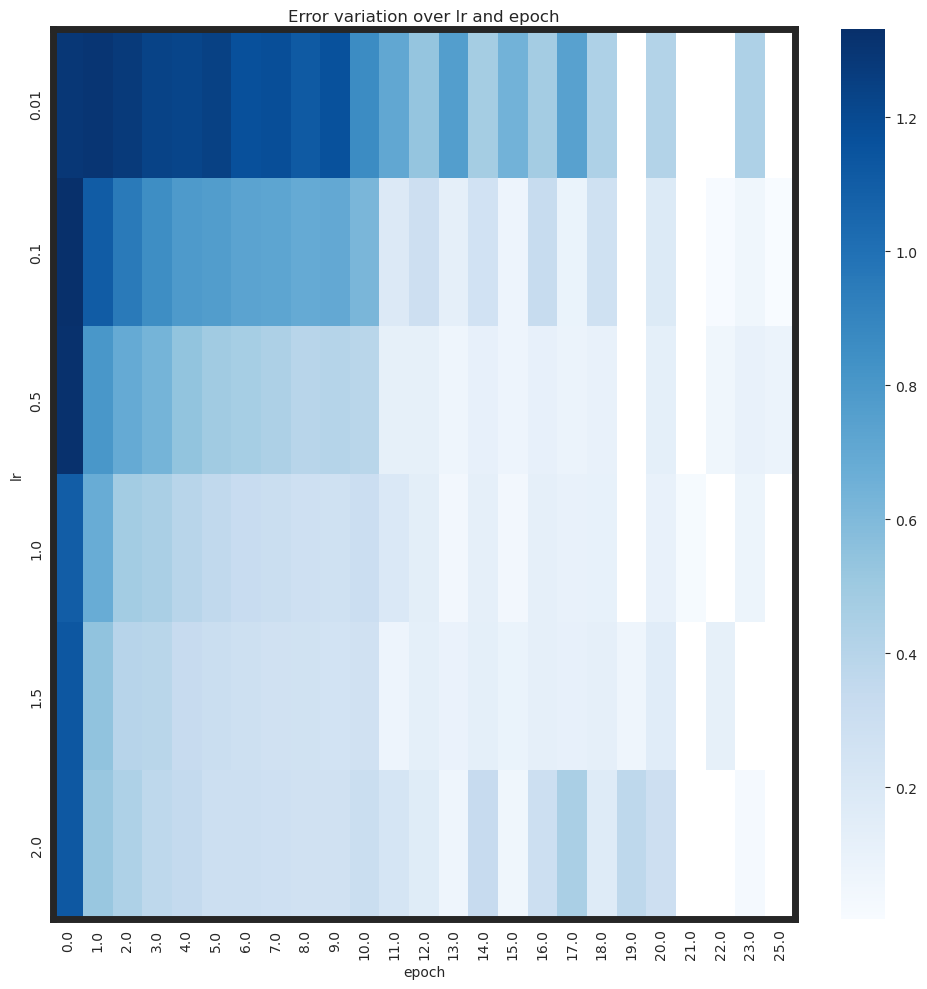

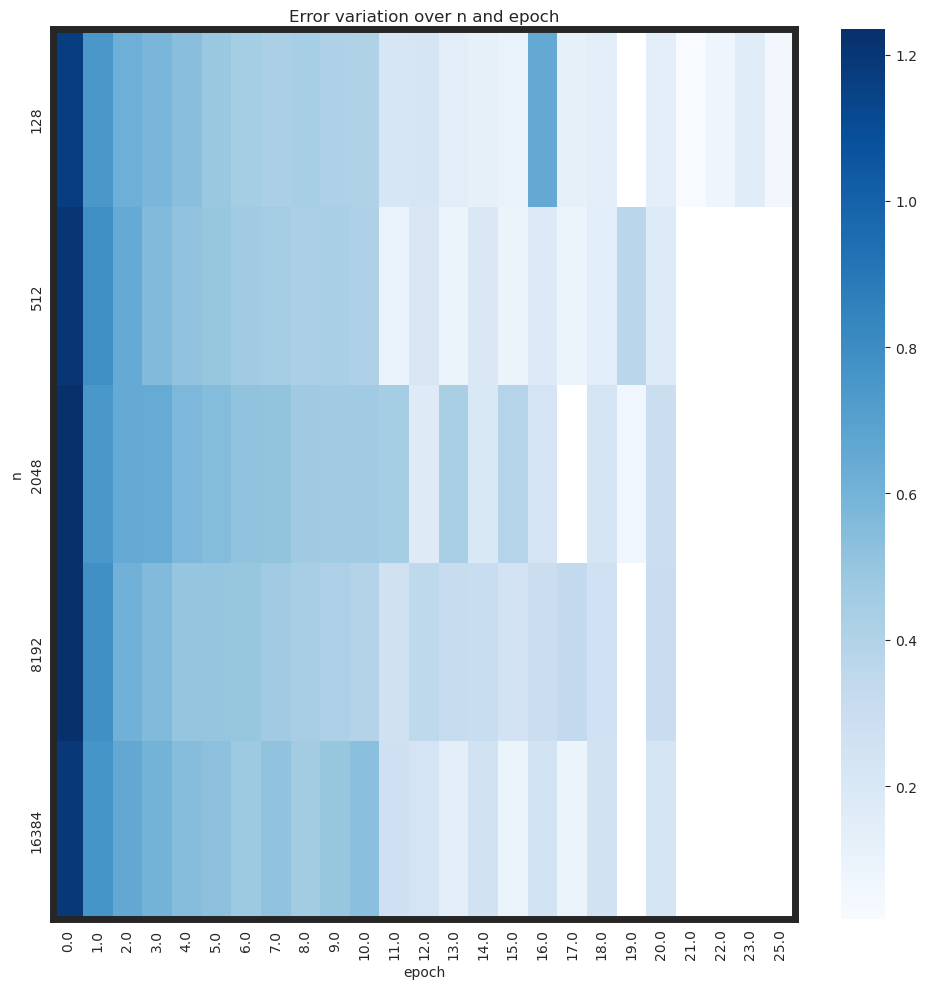

In [32]:
mask = ((end_of_epoch_df.error < e_max).to_numpy()) & ((end_of_epoch_df.bias == bias).to_numpy() ) #& (end_of_epoch_df.batch_size <= 0.5))
for y in ["batch_size", "lr", "n"]: 
    columns = ["epoch_idx", y, "error"]
    _df = end_of_epoch_df[mask][columns]
    # First, agg _df over run_idx
    grouped_df = _df.groupby(columns[:2])
    aggregated_df = grouped_df.aggregate({"error": "mean"}).reset_index()
    pivotted_df = aggregated_df.pivot(index=y, columns="epoch_idx", values="error")
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca()
    res = sns.heatmap(pivotted_df, cmap="Blues")
    # Drawing the frame
    for _, spine in res.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(5)

    ax.set_ylabel(y)
    ax.set_xlabel("epoch")
    ax.set_title(f"Error variation over {y} and epoch")
    fig.tight_layout()
    plt.savefig(os.path.join("outputs", "temporal_error", f"epoch_vs_{y}.png"))

# What about signed error

[D:2023-09-24 08:20:08,505][matplotlib.colorbar:876] locator: <matplotlib.ticker.AutoLocator object at 0x7f7e9e6cfb80>
[D:2023-09-24 08:20:09,001][matplotlib.colorbar:876] locator: <matplotlib.ticker.AutoLocator object at 0x7f7e9e07cbb0>
[D:2023-09-24 08:20:09,519][matplotlib.colorbar:876] locator: <matplotlib.ticker.AutoLocator object at 0x7f7e9d4dddb0>


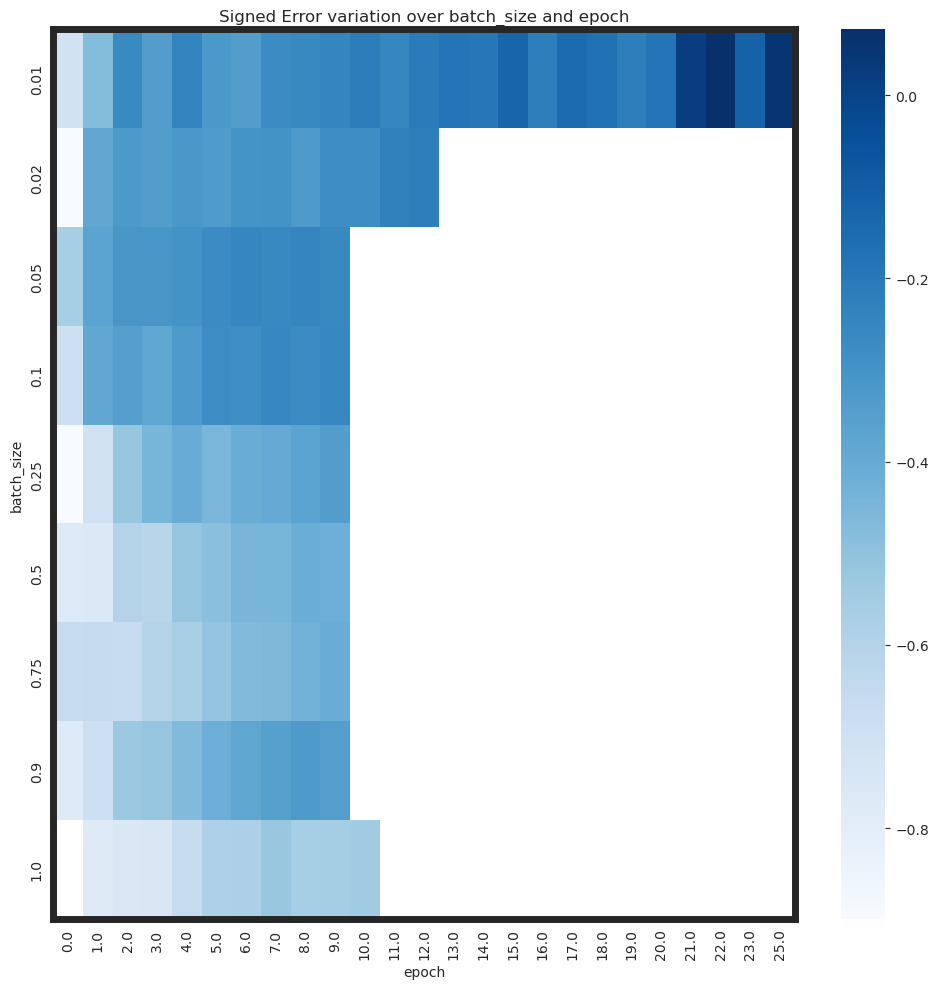

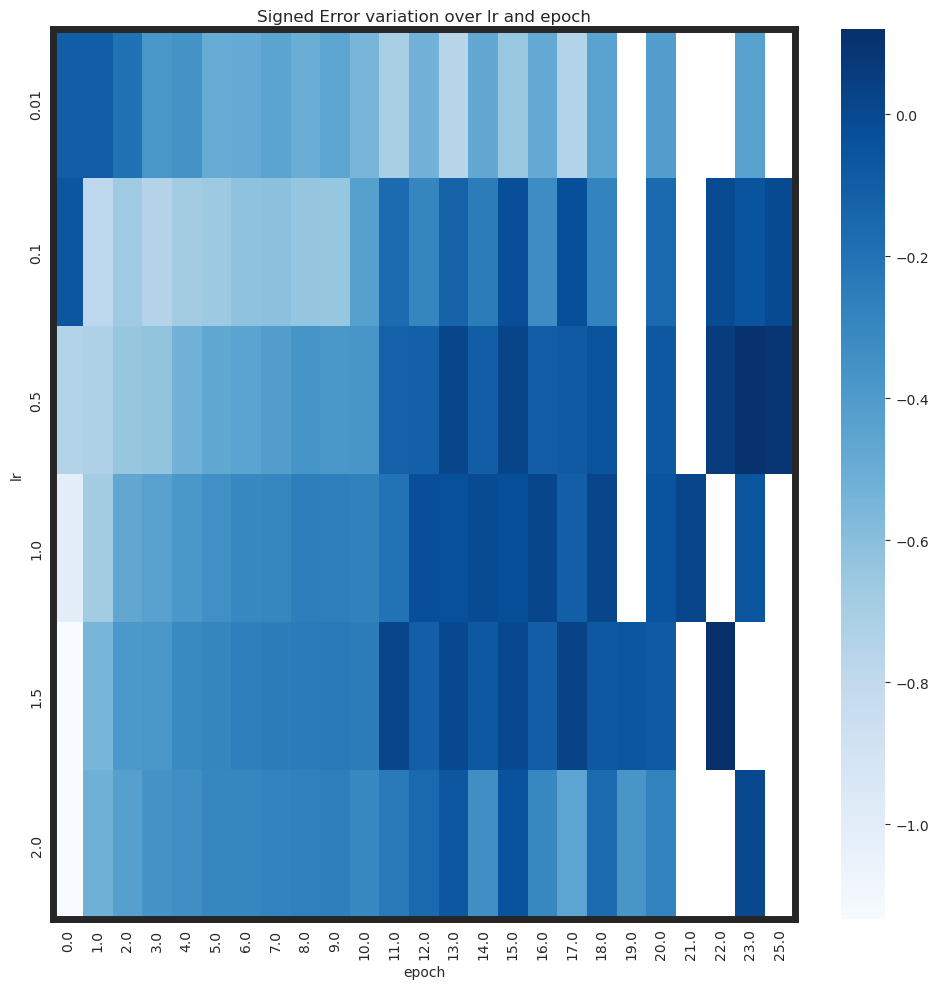

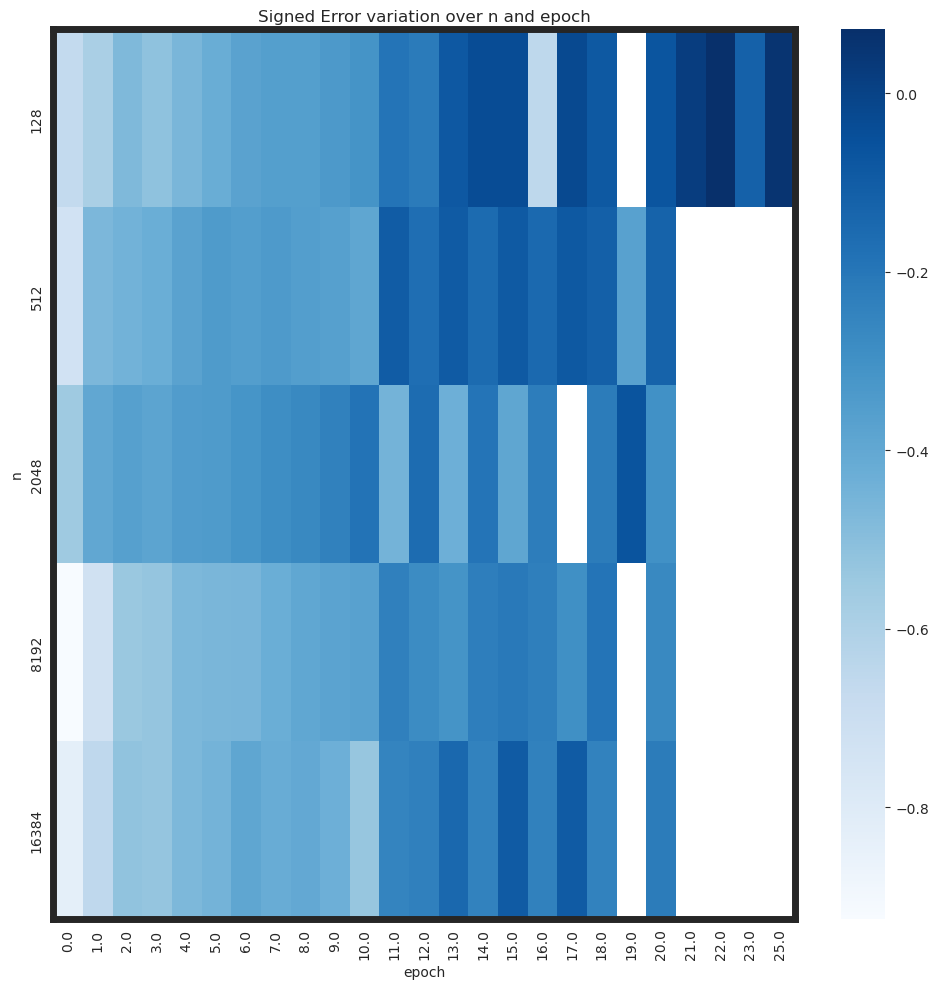

In [33]:
mask = ((end_of_epoch_df.sign_error > -e_max).to_numpy())  & ((end_of_epoch_df.sign_error < e_max).to_numpy()) & ((end_of_epoch_df.bias == bias).to_numpy() ) #& (end_of_epoch_df.batch_size <= 0.5))
for y in ["batch_size", "lr", "n"]: 
    columns = ["epoch_idx", y, "sign_error"]
    _df = end_of_epoch_df[mask][columns]
    # First, agg _df over run_idx
    grouped_df = _df.groupby(columns[:2])
    aggregated_df = grouped_df.aggregate({"sign_error": "mean"}).reset_index()
    pivotted_df = aggregated_df.pivot(index=y, columns="epoch_idx", values="sign_error")
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca()
    res = sns.heatmap(pivotted_df, cmap="Blues")
    # Drawing the frame
    for _, spine in res.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(5)

    ax.set_ylabel(y)
    ax.set_xlabel("epoch")
    ax.set_title(f"Signed Error variation over {y} and epoch")
    fig.tight_layout()
    plt.savefig(os.path.join("outputs", "temporal_error", f"epoch_vs_{y}_signed_error.png"))

<Axes: xlabel='signed_error', ylabel='Density'>

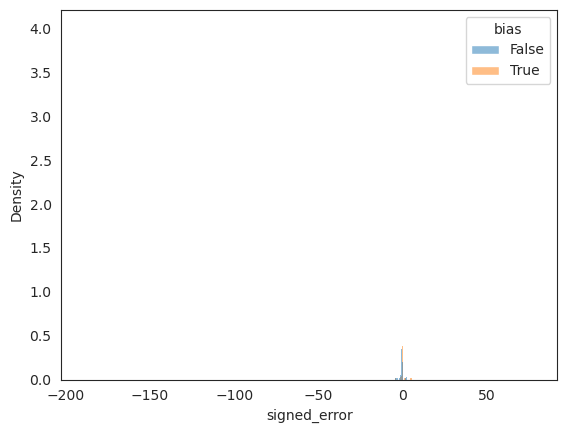

In [40]:
sns.histplot(data=data_df, x="signed_error", stat="density", hue="bias")

<Axes: xlabel='batch_size', ylabel='signed_error'>

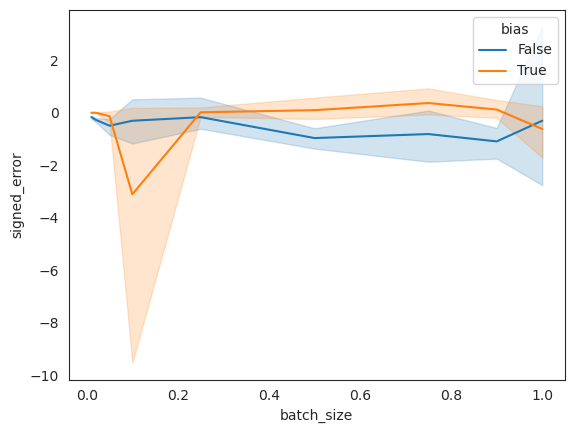

In [42]:
sns.lineplot(data_df, x="batch_size", y="signed_error", hue="bias")

<Axes: xlabel='lr', ylabel='signed_error'>

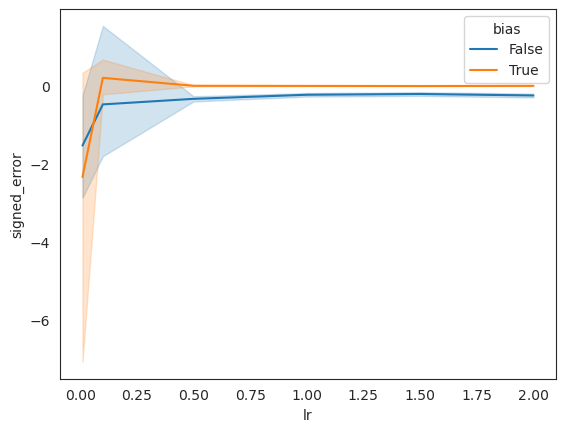

In [43]:
sns.lineplot(data_df, x="lr", y="signed_error", hue="bias")

<Axes: xlabel='n', ylabel='signed_error'>

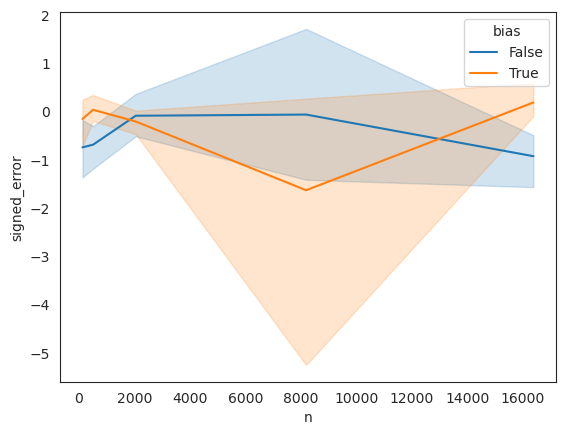

In [44]:
sns.lineplot(data_df, x="n", y="signed_error", hue="bias")